## AJILE 12 Data

In [1]:
from temporaldata import Data
import h5py
from datetime import timedelta

path = "/home/mila/s/sobralm/brainsets/data/processed/peterson_brunton_pose_trajectory_2022/AJILE12_P01_20000107_ses7_pose_trajectories.h5"
file = h5py.File(path, "r")
data = Data.from_hdf5(file, lazy=True)

### Basic information

In [2]:
print(f"Sampling rate: {data.ecog.sampling_rate} Hz")
print(f"Number of channels: {len(data.channels)}")
duration = timedelta(seconds=(data.ecog.domain.end - data.ecog.domain.start)[0])  
print(f"Duration: {duration} seconds")

Sampling rate: 500.0 Hz
Number of channels: 94
Duration: 15:28:37.584000 seconds


### Plot the data

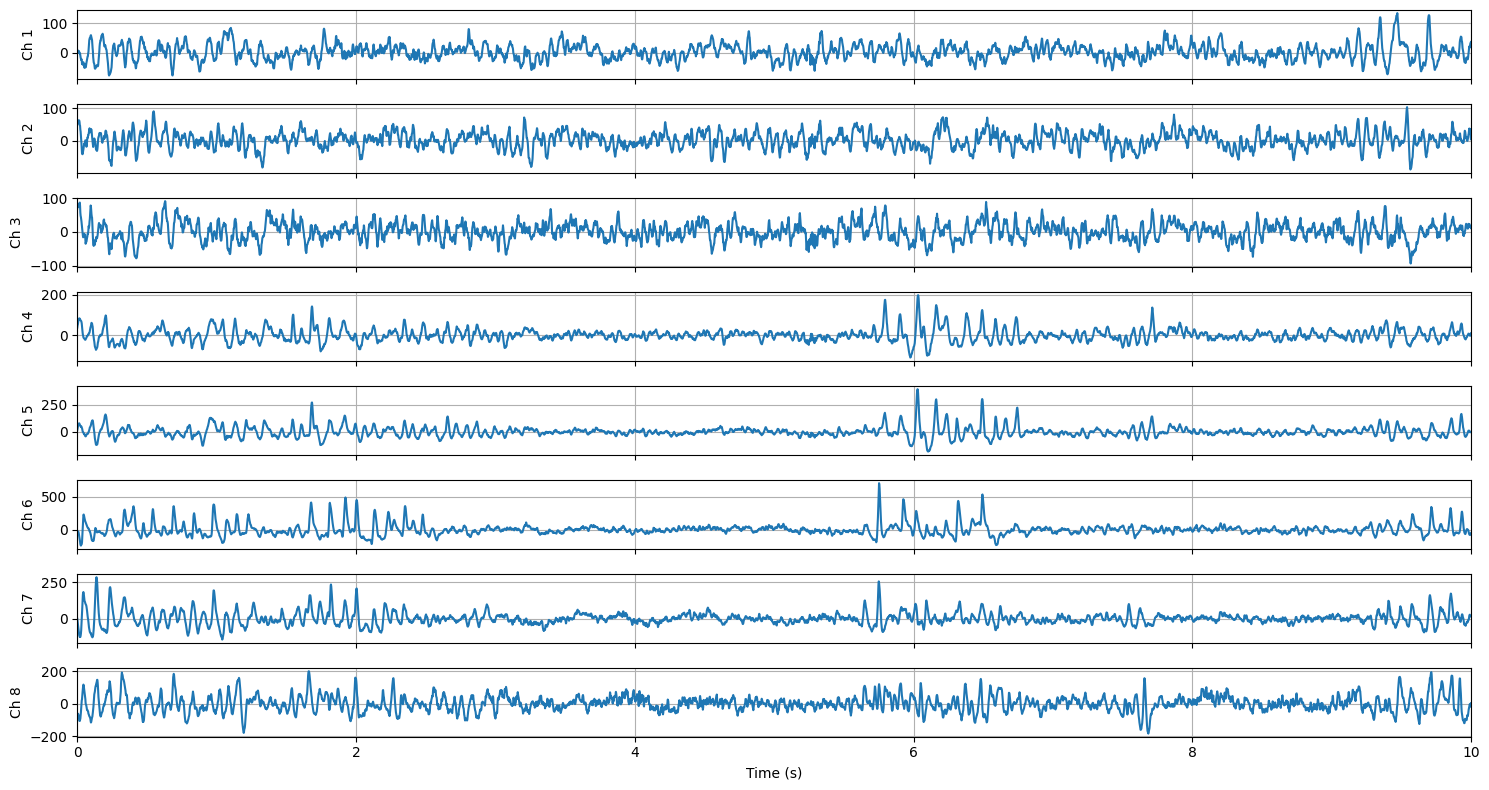

In [3]:
from matplotlib import pyplot as plt
import numpy as np

# Plot 10 seconds of 8 channels in 8 horizontal subplots
sampling_rate = data.ecog.sampling_rate
seconds_to_plot = 10
n_channels_to_plot = 8
start_time = 100
start_time_idx = int(start_time * sampling_rate)
end_time = start_time + seconds_to_plot
end_time_idx = int(end_time * sampling_rate)

fig, axes = plt.subplots(n_channels_to_plot, 1, figsize=(15, 8), sharex=True)
time_axis = (np.arange(end_time_idx - start_time_idx) / sampling_rate)

signal = data.ecog.signal[start_time_idx:end_time_idx, :n_channels_to_plot]

for ch in range(n_channels_to_plot):
    axes[ch].plot(time_axis, signal[:, ch])
    axes[ch].set_ylabel(f"Ch {ch+1}")
    axes[ch].set_xlim([0, seconds_to_plot])
    axes[ch].grid(True)
axes[-1].set_xlabel("Time (s)")
plt.tight_layout()
plt.show()

### Show the pose data

Pose data is stored in the `pose` attribute of the `Data` object.

It contains the following joints:
 * l_ear
 * r_ear
 * l_shoulder
 * r_shoulder
 * l_elbow
 * r_elbow
 * l_wrist
 * r_wrist
 * nose

KeyboardInterrupt: 

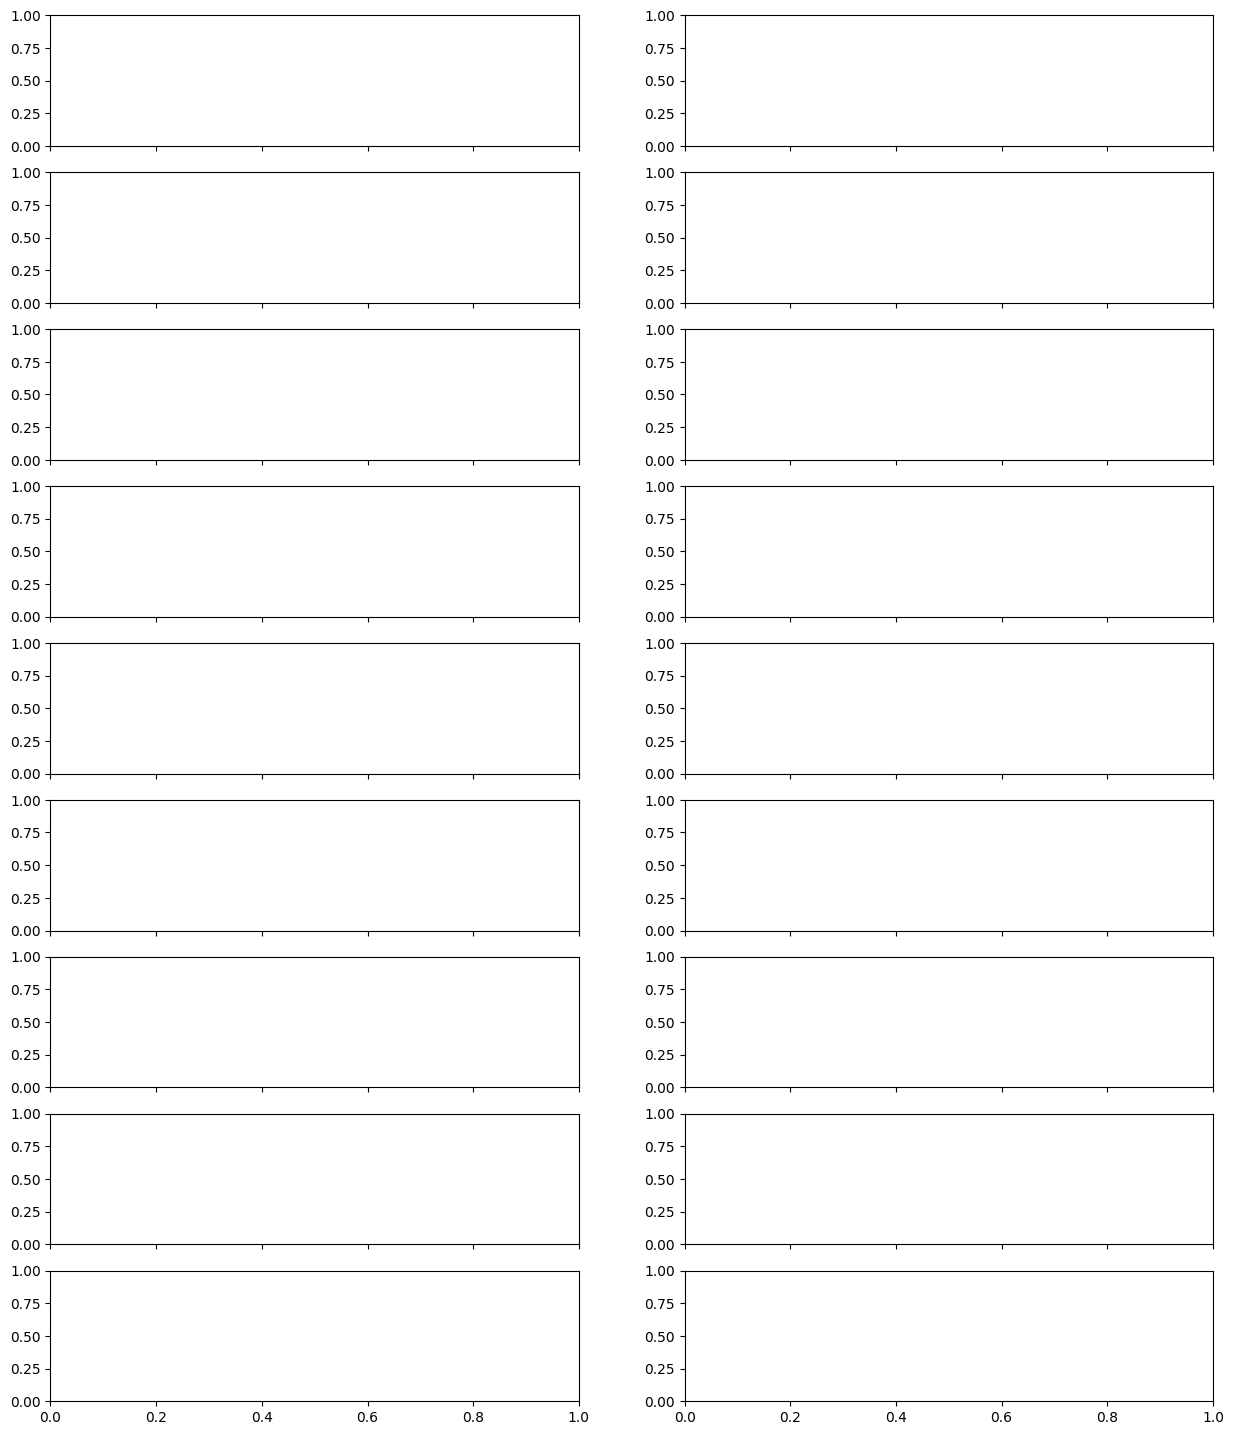

In [ ]:
# Plot 10 seconds of each joint, with each row as a joint and columns as x/y
# TODO: Reprendre ICI et simplifier les splits probablement
sampling_rate = data.pose.sampling_rate
seconds_to_plot = 10
start_time = 1000000
start_time_idx = int(start_time * sampling_rate)
end_time = start_time + seconds_to_plot
end_time_idx = int(end_time * sampling_rate)

joints = list(data.pose.keys())
n_joints = len(joints)
coords = ['x', 'y']

fig, axes = plt.subplots(n_joints, 2, figsize=(15, 2 * n_joints), sharex=True)
time_axis = (np.arange(end_time_idx - start_time_idx) / sampling_rate)

for row, joint in enumerate(joints):
    data_slice = data.pose.__getattribute__(joint)[start_time_idx:end_time_idx]
    for col, coord in enumerate(coords):
        axes[row, col].plot(time_axis, data_slice[:, col])
        axes[row, col].set_ylabel(f"{joint} {coord}")
        axes[row, col].set_xlim([0, seconds_to_plot])
        axes[row, col].grid(True)
axes[-1, 0].set_xlabel("Time (s)")
axes[-1, 1].set_xlabel("Time (s)")
plt.tight_layout()
plt.show()